In [46]:
#Импортируем библиотеки
from multiprocessing import Pool
import codecs
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot
%matplotlib inline

In [47]:
data = pd.read_csv("posts_all.csv", encoding="utf-8")
data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2608 entries, 0 to 2623
Data columns (total 2 columns):
text         2608 non-null object
Sentiment    2608 non-null float64
dtypes: float64(1), object(1)
memory usage: 61.1+ KB


,text,Sentiment
2619,I just wanted to let you know that your suppor...,4.0
2620,Not only that I am getting quick answers to al...,3.0
2621,In 2015 we bought the full DevExpress Universa...,4.0
2622,After 25 Years of professional windows develop...,4.0
2623,AWESOME !,4.0


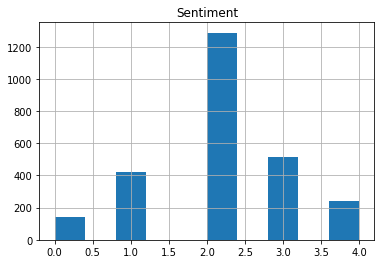

In [48]:
data.info()
#Гистограмма распределения классов 
data.hist(column=["Sentiment"])
data.tail()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B0240F940>]],
      dtype=object)

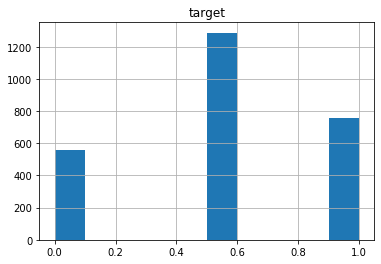

In [49]:
data["target"] = data.Sentiment.apply(lambda x: 1 if x > 2 else 0 if x < 2 else 0.5)
data.hist(column=["target"])

In [50]:
#The data store in really imbalanced
#Let's try the over sampling technice

import random 
classes = np.unique(data.target.values)
amount_classes = data.groupby("target").count().text.values
max_amount = max(amount_classes)
for cl_index in range(len(classes)):
    cl = classes[cl_index]
    cl_slice = data[data.target == cl]
    amount = amount_classes[cl_index]
    samples_to_add = max_amount - amount
    while samples_to_add > 0:
        sample_index = random.randint(0, amount - 1)

        data = data.append(cl_slice.iloc[sample_index])
        samples_to_add -= 1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3864 entries, 0 to 1487
Data columns (total 3 columns):
text         3864 non-null object
Sentiment    3864 non-null float64
target       3864 non-null float64
dtypes: float64(2), object(1)
memory usage: 120.8+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B02AAFFD0>]],
      dtype=object)

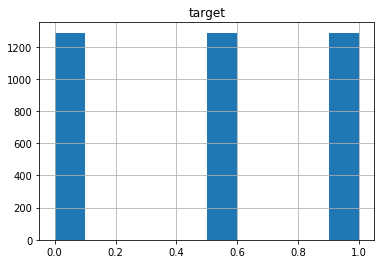

In [51]:
data.info()
data.hist(column=["target"])

In [52]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC

X = data.text.values
Y = data.target.values

In [11]:
#Импортируем доп библиотеки
from sklearn.pipeline import Pipeline
#Подбор лучших параметров
from sklearn.model_selection import GridSearchCV

#Функция создания каскада - пайплайна из ветроризатора, трансформатора и класификатора
def text_classifier(vectorizer, classifier, transformer=None):
    if (transformer is None) :
        return Pipeline(
                [("vectorizer", vectorizer),
                 ("classifier", classifier)]
            )
    else: 
        return Pipeline(
            [("vectorizer", vectorizer),
             ("transformer", transformer),
            ("classifier", classifier)]
        )

In [ ]:
# the best parameters search for the level 1 estimator
ngram_range = [(2,4),(2,5),(3,5),(2,6),(3,6),(4,6)]
param_grid = {
    "vectorizer": [TfidfVectorizer(), CountVectorizer()],
    "vectorizer__analyzer": ["char", "char_wb", "word"],
    "vectorizer__ngram_range": ngram_range,
    "vectorizer__stop_words": [None, "english"],
    "classifier": [LinearRegression()],
    #"vectorizer__max_df": np.arange(0.95, 1.0, 0.02),
    #"vectorizer__min_df": np.arange(0.0, 0.10, 0.05),
}

pipLine = text_classifier(CountVectorizer(), LinearSVC())
gridSearchCV = GridSearchCV(pipLine, scoring="max_error", 
                            param_grid=param_grid,
                            cv=5,
                           )
gridSearchCV.fit(X, Y)

print("best params", gridSearchCV.best_params_)
print("best score", gridSearchCV.best_score_)

In [ ]:
# the best parameters search for the level 2 estimator

Y_classes = data.Sentiment.apply(lambda x: 1 if x > 2 else -1 if x < 2 else 0).values

ngram_range = [(2,4),(2,5),(3,5),(2,6),(3,6),(4,6)]
param_grid = {
    "vectorizer": [TfidfVectorizer(), CountVectorizer()],
    "vectorizer__analyzer": ["char", "char_wb", "word"],
    "vectorizer__ngram_range": ngram_range,
    "vectorizer__stop_words": [None, "english"],
    "classifier": [LogisticRegression(multi_class="multinomial", 
                                      solver="lbfgs",
                                      max_iter=200   
                                     )],
    #"vectorizer__max_df": np.arange(0.95, 1.0, 0.02),
    #"vectorizer__min_df": np.arange(0.0, 0.10, 0.05),
}

pipLine = text_classifier(CountVectorizer(), LogisticRegression())
gridSearchCV = GridSearchCV(pipLine, 
                            cv=5,
                            param_grid=param_grid)
gridSearchCV.fit(X, Y_classes)

print("best params", gridSearchCV.best_params_)
print("best score", gridSearchCV.best_score_)

In [160]:
from sklearn.model_selection import train_test_split
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(4, 6), max_df=0.95, stop_words='english')
X_vec = vectorizer.fit_transform(X)

#X_train, X_test, Y_train, Y_test = train_test_split(X_vec, Y, test_size=0.33)

linear_classifier = LinearRegression()
linear_classifier.fit(X_vec, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [161]:
#print("Train",
#      linear_classifier.score(X_train, Y_train),
      #"Test",
      #linear_classifier.score(X_test, Y_test)
#     )

In [162]:
l2_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(4, 6), max_df=0.95)
X_vec_l2 = l2_vectorizer.fit_transform(X)

linear_estimation = np.array([list([v]) for v in linear_classifier.predict(X_vec)])
X_epanded = np.hstack((X_vec_l2.toarray(), linear_estimation))
Y_classes = data.Sentiment.apply(lambda x: 1 if x > 2 else -1 if x < 2 else 0).values

In [57]:
#X_train, X_test, Y_train, Y_test = train_test_split(X_epanded, Y_classes, test_size=0.33)


log_classifier = LogisticRegression(solver="lbfgs", 
                                    multi_class="multinomial", 
                                    max_iter=200)
log_classifier.fit(X_epanded, Y_classes)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
#print("Train",
#      log_classifier.score(X_train, Y_train),
#      "Test",
#      log_classifier.score(X_test, Y_test))

print(cross_val_score(log_classifier, X_epanded, Y_classes, cv=5))

[0.93669251 0.94056848 0.95348837 0.91050584 0.90142672]


In [59]:
print(len(X) - 1)
test_index = 2989
print(X[test_index],
      "Prediction - ",
      log_classifier.predict([X_epanded[test_index]])[0])
print("The real value is - ",
     Y_classes[test_index])
print(log_classifier.predict_proba([X_epanded[test_index]]))

3863
I feel it crazy and would not recommend to my friends who think much of DevOps. Prediction -  -1
The real value is -  -1
[[9.98647807e-01 1.04850993e-03 3.03683275e-04]]


In [60]:
import pickle
#Сохранение данных в файл с помощью pickle
pickle.dump(linear_classifier, open( "l1_Classifier.pkl", "wb" ))
pickle.dump(vectorizer, open( "l1_vectorizer.pkl", "wb" ))
pickle.dump(log_classifier, open( "l2_Classifier.pkl", "wb" ))
pickle.dump(l2_vectorizer, open( "l2_vectorizer.pkl", "wb" ))

In [163]:
def rebalanse_set(data, labels):
    classes = np.unique(labels)
    fric_d = dict()
    for cl in classes:
        fric_d.setdefault(cl, 0)
        
    for label in labels:
        fric_d[label] += 1
        
    max_amount = max(fric_d.values())

    new_data = np.copy(data)
    new_labels = np.copy(labels)
    for cl_index in range(len(classes)):
        cl = classes[cl_index]
        cl_slice = data[np.where(labels == cl)[0]]
        amount = fric_d[cl]
        samples_to_add = max_amount - amount

        new_labels = np.concatenate((new_labels, samples_to_add*[cl]))
        while samples_to_add > 0:
            sample_index = random.randint(0, amount - 1)
            new_data = np.append(new_data, cl_slice[sample_index])
            samples_to_add -= 1

    return new_data, new_labels
    
data = np.array([1, 2, 3, 4, 5, 6, 7])
labels = np.array([1, 1, 1, 1, 1, 0, 1])
new_data, labels_new = rebalanse_set(data, labels)

assert(len(new_data) == 12)

In [166]:
def converToBinary(targetValue, labels, prediction):
    binariezedLabelds = np.array([(1 if x==targetValue else 0) for x in labels])
    binariezedPredictions = np.array([(1 if x==targetValue else 0) for x in prediction])
    return binariezedLabelds, binariezedPredictions

def printSummary(val_acc, val_recall, val_precision, val_f_measure):
    print("+++++++++++++++++%s+++++++++++++++++" % "Summary")
    print("Valication accuracy for the 'bad' class is %f" % np.mean(val_acc[0]))
    print("Valication accuracy for the 'neutral' class is %f" % np.mean(val_acc[1]))
    print("Valication accuracy for the 'good' class is %f" % np.mean(val_acc[2]))

    print("Valication recall for the 'bad' class is %f" % np.mean(val_recall[0]))
    print("Valication recall for the 'neutral' class is %f" % np.mean(val_recall[1]))
    print("Valication recall for the 'good' class is %f" % np.mean(val_recall[2]))

    print("Valication precision for the 'bad' class is %f" % np.mean(val_precision[0]))
    print("Valication precision for the 'neutral' class is %f" % np.mean(val_precision[1]))
    print("Valication precision for the 'good' class is %f" % np.mean(val_precision[2]))

    print("Valication f_measure for the 'bad' class is %f" % np.mean(val_f_measure[0]))
    print("Valication f_measure for the 'neutral' class is %f" % np.mean(val_f_measure[1]))
    print("Valication f_measure for the 'good' class is %f" % np.mean(val_f_measure[2]))

def validateForClass(classId, Y_classes_test, prediction, val_acc, val_recall, val_precision,
val_f_measure):
    binariezedLabelds, binariezedPredictions = converToBinary(classId, 
                    Y_classes_test,
                    prediction)
    #Cals measures only if we have actual values in a sub set 
    if (sum(binariezedLabelds) != 0):
        acc = accuracy_score(binariezedLabelds, binariezedPredictions)
        recall = recall_score(binariezedLabelds, binariezedPredictions)
        precision = precision_score(binariezedLabelds, binariezedPredictions)
        f_measure = f1_score(binariezedLabelds, binariezedPredictions)

        index = classes.index(classId) 
        val_acc[index].append(acc)
        val_recall[index].append(recall)
        val_precision[index].append(precision)
        val_f_measure[index].append(f_measure)

def create_l2_classifier(linear_classifier, X_l2_train, Y_classes_train):
    lin_e_train = np.array([list([v]) for v in linear_classifier.predict(X_l1_train)])
    X_l2_extended_train = np.hstack((X_l2_train.toarray(), lin_e_train))
    
    log_classifier = LogisticRegression(solver="lbfgs", 
                                        multi_class="ovr")
    log_classifier.fit(X_l2_extended_train, Y_classes_train)
    return log_classifier

def init_variables(X, Y_classes, train_index, test_index): 
    X_train, Y_classes_train = rebalanse_set(X[train_index], Y_classes[train_index])

    return (vectorizer.transform(X_train), vectorizer.transform(X[test_index]), 
            l2_vectorizer.transform(X_train), l2_vectorizer.transform(X[test_index]),
            Y_classes_train, Y_classes[test_index])

In [167]:
#Now let's calc valition metrics for Max
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

data = pd.read_csv("posts_all.csv", encoding="utf-8")
data.dropna(inplace=True)

#Create target column
data["target"] = data.Sentiment.apply(lambda x: 1 if x > 2 else 0 if x < 2 else 0.5)
#extract values
X = data.text.values
Y = data.target.values
Y_classes = data.Sentiment.apply(lambda x: 1 if x > 2 else -1 if x < 2 else 0).values


val_acc = [[],[],[]]
val_recall = [[],[],[]]
val_precision = [[],[],[]]
val_f_measure = [[],[],[]]


classes = [-1, 0, 1]

from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
folds_i = 0
for train_index, test_index in kf.split(X_l1):
    (X_l1_train, X_l1_test, 
     X_l2_train, X_l2_test, 
     Y_classes_train, Y_classes_test) = init_variables(X, 
                                                       Y_classes, 
                                                       train_index, test_index) 
    print("++++++++++++++++++++++++%d++++++++++++++++++++++++" % folds_i)
    #create level 1 estimator
    linear_classifier = LinearRegression()
    linear_classifier.fit(X_l1_train, Y_classes_train)
        
    #prepare data for the level 2 classifier
    log_classifier = create_l2_classifier(linear_classifier, 
                                          X_l2_train, Y_classes_train)
    
    lin_e_test = np.array([list([v]) for v in linear_classifier.predict(X_l1_test)])
    X_l2_extended_test = np.hstack((X_l2_test.toarray(), lin_e_test))
    prediction = log_classifier.predict(X_l2_extended_test)
    #Estimate metrics
    for targetValue in classes: 
        validateForClass(targetValue, 
                         Y_classes_test, 
                         prediction, 
                         val_acc, 
                         val_recall,
                         val_precision,
                         val_f_measure
                        )
    folds_i += 1

printSummary(val_acc, val_recall,val_precision,val_f_measure)

++++++++++++++++++++++++0++++++++++++++++++++++++


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


++++++++++++++++++++++++1++++++++++++++++++++++++


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


++++++++++++++++++++++++2++++++++++++++++++++++++


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


++++++++++++++++++++++++3++++++++++++++++++++++++


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


++++++++++++++++++++++++4++++++++++++++++++++++++


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


++++++++++++++++++++++++5++++++++++++++++++++++++


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


++++++++++++++++++++++++6++++++++++++++++++++++++


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


++++++++++++++++++++++++7++++++++++++++++++++++++
++++++++++++++++++++++++8++++++++++++++++++++++++
++++++++++++++++++++++++9++++++++++++++++++++++++


C:\Users\Maks Konyaev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


+++++++++++++++++Summary+++++++++++++++++
Valication accuracy for the 'bad' class is 0.857303
Valication accuracy for the 'neutral' class is 0.865287
Valication accuracy for the 'good' class is 0.900333
Valication recall for the 'bad' class is 0.548400
Valication recall for the 'neutral' class is 0.836794
Valication recall for the 'good' class is 0.854087
Valication precision for the 'bad' class is 0.660192
Valication precision for the 'neutral' class is 0.814340
Valication precision for the 'good' class is 0.669151
Valication f_measure for the 'bad' class is 0.521536
Valication f_measure for the 'neutral' class is 0.822638
Valication f_measure for the 'good' class is 0.729593
